## The Battle of Neighborhoods (Week 2)

My previous notebook stated that I would be exploring 5 different major cities to determine the best spot to open a pizza restaurant.
<br>
I will now be changing that to only exploring 2 major cities.
<br>
- **Philadelphia** and **Pittsburgh, PA**.

**Exploring the data:**

In [3]:
import pandas as pd
import numpy as np
import requests

**Finding center of cities:**

In [5]:
# ! pip install folium==0.7.0

In [6]:
from geopy.geocoders import Nominatim
import folium

In [7]:
cities_list = []

# cities = ['New York, NY', 'Philadelphia, PA', 'Boston, MA', 'Baltimore, MD', 'Pittsburgh, PA']
cities = ['Philadelphia, PA', 'Pittsburgh, PA']

for city in cities:
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(city)
    latitude = location.latitude
    longitude = location.longitude
    cities_list.append([city.split(',')[0].upper(),[latitude, longitude]])
print(cities_list)

[['PHILADELPHIA', [39.9527237, -75.1635262]], ['PITTSBURGH', [40.4416941, -79.9900861]]]


**Setting up variables for query:**

In [8]:
CLIENT_ID = 'WUPUAH5PA54ZBTSDADZUGWT0ROUITGR5S1ZPV3EIV1DYIVP3'
CLIENT_SECRET = 'F0VENJWDIYB3JQYW3DOON402F0DK34O2MSR42145SCXS0UYM'
VERSION = '20201101'
LIMIT = 100
RADIUS = 8046 # meters
SEARCH_QUERY = 'Pizza'

In [9]:
for x in cities_list:
    LAT = x[1][0]
    LNG = x[1][1]
#     print(LAT,LNG)

In [10]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}&limit={}'.format(CLIENT_ID,CLIENT_SECRET,VERSION,LAT,LNG,SEARCH_QUERY,RADIUS,LIMIT)

In [11]:
results = requests.get(url).json()

In [12]:
venues = results['response']['venues']
dataframe = pd.json_normalize(venues)

<hr>

## Philadelphia's Restaurants:

**Exploring the Pizza restaurants in this city:**

In [13]:
phil = cities_list[0][1]
phil_lat = phil[0]
phil_lng = phil[1]
phil_url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}&limit={}'.format(CLIENT_ID,CLIENT_SECRET,VERSION,phil_lat,phil_lng,SEARCH_QUERY,RADIUS,LIMIT)
results = requests.get(phil_url).json()
venues = results['response']['venues']
phil_df = pd.json_normalize(venues)

**Cleaning the phil_df dataframe:**

In [14]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in phil_df.columns if col.startswith('location.')] + ['id']
dataframe_filtered = phil_df.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

In [15]:
phil_df = dataframe_filtered

In [16]:
phil_df.head()

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,neighborhood,id
0,Jake's Pizza,Pizza Place,201 N Broad St,at Race St,39.956123,-75.162536,"[{'label': 'display', 'lat': 39.95612338396027...",387,19107,US,Philadelphia,PA,United States,"[201 N Broad St (at Race St), Philadelphia, PA...",NaN,4b3d274ff964a520138f25e3
1,Rex Pizza,Pizza Place,1526 Race St,NaN,39.956430,-75.165591,"[{'label': 'display', 'lat': 39.95642960191507...",448,19102,US,Philadelphia,PA,United States,"[1526 Race St, Philadelphia, PA 19102, United ...",NaN,4bae4b82f964a520c99e3be3
2,Joe's Pizza,Pizza Place,122 S 16th St,at Sansom St,39.950372,-75.167422,"[{'label': 'display', 'lat': 39.95037232183254...",423,19102,US,Philadelphia,PA,United States,"[122 S 16th St (at Sansom St), Philadelphia, P...",NaN,4ac641bef964a52066b320e3
3,Mix Brick Oven Pizza,Pizza Place,2101 Chestnut St,at 21st St,39.952399,-75.175665,"[{'label': 'display', 'lat': 39.95239907148592...",1036,19103,US,Philadelphia,PA,United States,"[2101 Chestnut St (at 21st St), Philadelphia, ...",NaN,4aca8c71f964a52052c220e3
4,Zio's Pizza,Pizza Place,111 S 13th St,13th & Sansom,39.950071,-75.161920,"[{'label': 'display', 'lat': 39.95007113634469...",325,19107,US,Philadelphia,PA,United States,"[111 S 13th St (13th & Sansom), Philadelphia, ...",NaN,4a9ff82af964a520c83d20e3


**Let's plot these restaurants on a map:**

In [18]:
phil_map = folium.Map(location=[phil_lat,phil_lng], zoom_start=14)

folium.CircleMarker(
    [phil_lat,phil_lng],
    radius=10,
    color='red',
    popup='Philadelphia, PA',
    fill=True,
    fill_color='red',
    fill_opacity=0.6
).add_to(phil_map)

for lat, lng, label in zip(phil_df.lat, phil_df.lng, phil_df.name):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill=True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(phil_map)
    
phil_map

Map Link: https://github.com/theblindhobo/Coursera_Capstone/blob/master/Screenshot%202020-11-02%20200343.png

<br><br>

**KMeans Cluster to find the best spot for a delivery service:**

In [25]:
import matplotlib.pyplot as plt
from sklearn import preprocessing, cluster
import scipy
from scipy.cluster.vq import vq

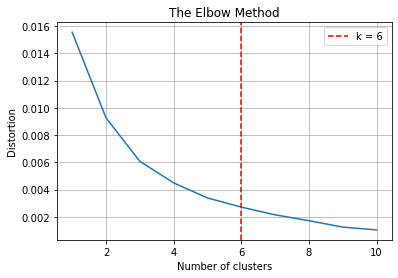

In [22]:
X = phil_df[["lat","lng"]]
max_k = 10
## iterations
distortions = [] 
for i in range(1, max_k+1):
    if len(X) >= i:
        model = cluster.KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        model.fit(X)
        distortions.append(model.inertia_)
        
## best k: the lowest derivative
k = [i*100 for i in np.diff(distortions,2)].index(min([i*100 for i in np.diff(distortions,2)]))

## plot
fig, ax = plt.subplots()
ax.plot(range(1, len(distortions)+1), distortions)
ax.axvline(k, ls='--', color="red", label="k = "+str(k))
ax.set(title='The Elbow Method', xlabel='Number of clusters', ylabel="Distortion")
ax.legend()
ax.grid(True)
plt.show()

**Let's use k=6 as that seems to be the best choice here.**

In [31]:
k = 6
model = cluster.KMeans(n_clusters=k, init='k-means++')
X = phil_df[["lat","lng"]]

## clustering
dtf_X = X.copy()
dtf_X["cluster"] = model.fit_predict(X)

## find real centroids
closest, distances = vq(model.cluster_centers_, dtf_X.drop("cluster", axis=1).values)
dtf_X["centroids"] = 0
for i in closest:
    dtf_X["centroids"].iloc[i] = 1
    
## add clustering info to the original dataset
phil_df[["cluster","centroids"]] = dtf_X[["cluster","centroids"]]
phil_df.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,neighborhood,id,cluster,centroids
0,Jake's Pizza,Pizza Place,201 N Broad St,at Race St,39.956123,-75.162536,"[{'label': 'display', 'lat': 39.95612338396027...",387,19107,US,Philadelphia,PA,United States,"[201 N Broad St (at Race St), Philadelphia, PA...",NaN,4b3d274ff964a520138f25e3,4,0
1,Rex Pizza,Pizza Place,1526 Race St,NaN,39.956430,-75.165591,"[{'label': 'display', 'lat': 39.95642960191507...",448,19102,US,Philadelphia,PA,United States,"[1526 Race St, Philadelphia, PA 19102, United ...",NaN,4bae4b82f964a520c99e3be3,4,0
2,Joe's Pizza,Pizza Place,122 S 16th St,at Sansom St,39.950372,-75.167422,"[{'label': 'display', 'lat': 39.95037232183254...",423,19102,US,Philadelphia,PA,United States,"[122 S 16th St (at Sansom St), Philadelphia, P...",NaN,4ac641bef964a52066b320e3,4,0
3,Mix Brick Oven Pizza,Pizza Place,2101 Chestnut St,at 21st St,39.952399,-75.175665,"[{'label': 'display', 'lat': 39.95239907148592...",1036,19103,US,Philadelphia,PA,United States,"[2101 Chestnut St (at 21st St), Philadelphia, ...",NaN,4aca8c71f964a52052c220e3,5,0
4,Zio's Pizza,Pizza Place,111 S 13th St,13th & Sansom,39.950071,-75.161920,"[{'label': 'display', 'lat': 39.95007113634469...",325,19107,US,Philadelphia,PA,United States,"[111 S 13th St (13th & Sansom), Philadelphia, ...",NaN,4a9ff82af964a520c83d20e3,4,1


**Plot the clusters and centroids to better visualize the data:**

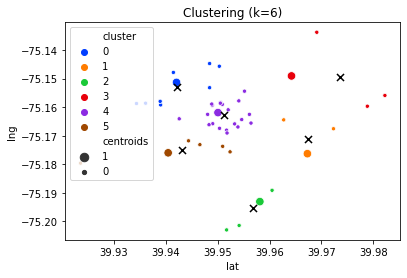

In [33]:
import seaborn as sns
## plot
fig, ax = plt.subplots()
sns.scatterplot(x="lat", y="lng", data=phil_df, palette=sns.color_palette("bright",k), hue='cluster', size="centroids", size_order=[1,0], legend="brief", ax=ax).set_title('Clustering (k='+str(k)+')')
th_centroids = model.cluster_centers_
ax.scatter(th_centroids[:,0], th_centroids[:,1], s=50, c='black', marker="x")

In [68]:
phil_df['cluster'].value_counts().max(level=0)

4    21
0     9
5     6
2     6
3     4
1     4
Name: cluster, dtype: int64

**We can see that cluster #4 has the most entries in it, so we will go with this cluster for this city.**
<br><br>
Let's find the centroid of that cluster.

In [71]:
phil_cluster_df = phil_df[(phil_df['cluster'] == 4) & (phil_df['centroids'] == 1)]
phil_cluster_df

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,neighborhood,id,cluster,centroids
4,Zio's Pizza,Pizza Place,111 S 13th St,13th & Sansom,39.950071,-75.16192,"[{'label': 'display', 'lat': 39.95007113634469...",325,19107,US,Philadelphia,PA,United States,"[111 S 13th St (13th & Sansom), Philadelphia, ...",NaN,4a9ff82af964a520c83d20e3,4,1


**Zio's Pizza in Philadelphia would be the closest restaurant we would want to center our delivery service around.**
<br>
That is, if Philadelphia is the city we choose to open in.
<br><br>
**The next city would have to have a cluster higher than "21" restaurants nearby for us to choose that city.**
<br>
Let's see..

<hr>

## Pittsburgh's restaurants:**

**Exploring the Pizza restaurants in this city:**

In [72]:
pitt = cities_list[1][1]
pitt_lat = pitt[0]
pitt_lng = pitt[1]
pitt_url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}&limit={}'.format(CLIENT_ID,CLIENT_SECRET,VERSION,pitt_lat,pitt_lng,SEARCH_QUERY,RADIUS,LIMIT)
results = requests.get(pitt_url).json()
venues = results['response']['venues']
pitt_df = pd.json_normalize(venues)

**Cleaning the data in pitt_df:**

In [73]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in pitt_df.columns if col.startswith('location.')] + ['id']
dataframe_filtered = pitt_df.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

In [74]:
pitt_df = dataframe_filtered

In [75]:
pitt_df.head()

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,neighborhood,crossStreet,id
0,Pizza Milano,Pizza Place,1304 5th Ave,40.438582,-79.987962,"[{'label': 'display', 'lat': 40.4385821185373,...",390,15219,US,Pittsburgh,PA,United States,"[1304 5th Ave, Pittsburgh, PA 15219, United St...",NaN,NaN,4ade2a17f964a520807321e3
1,Pizza Parma,Pizza Place,963 Liberty Ave,40.443770,-79.995820,"[{'label': 'display', 'lat': 40.44377, 'lng': ...",537,15222,US,Pittsburgh,PA,United States,"[963 Liberty Ave, Pittsburgh, PA 15222, United...",NaN,NaN,4b761d05f964a5208f3d2ee3
2,Genoa Pizza and Bar,Pizza Place,111 Market St,40.439001,-80.003671,"[{'label': 'display', 'lat': 40.43900068922535...",1189,15222,US,Pittsburgh,PA,United States,"[111 Market St, Pittsburgh, PA 15222, United S...",NaN,NaN,4b166f06f964a52005b923e3
3,Domino's Pizza,Pizza Place,300 6th Ave Uppr 100,40.441832,-79.999361,"[{'label': 'display', 'lat': 40.44183246264836...",785,15222,US,Pittsburgh,PA,United States,"[300 6th Ave Uppr 100, Pittsburgh, PA 15222, U...",NaN,NaN,4c7fdfe22f1c236ab0952143
4,Napoli's Pizza,Pizza Place,1525 5th Ave,40.438725,-79.984352,"[{'label': 'display', 'lat': 40.43872451782226...",587,15219,US,Pittsburgh,PA,United States,"[1525 5th Ave, Pittsburgh, PA 15219, United St...",NaN,NaN,4da518c24df00f31b175f0db


**Let's plot these restaurants on a map:**

In [77]:
pitt_map = folium.Map(location=[pitt_lat,pitt_lng], zoom_start=14)

folium.CircleMarker(
    [pitt_lat,pitt_lng],
    radius=10,
    color='red',
    popup='Pittsburgh, PA',
    fill=True,
    fill_color='red',
    fill_opacity=0.6
).add_to(pitt_map)

for lat, lng, label in zip(pitt_df.lat, pitt_df.lng, pitt_df.name):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill=True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(pitt_map)
    
pitt_map

Map Link: https://github.com/theblindhobo/Coursera_Capstone/blob/master/Screenshot%202020-11-02%20200443.png

<br><br>

**KMeans Cluster to find the best spot for a delivery service:**

In [78]:
import matplotlib.pyplot as plt
from sklearn import preprocessing, cluster
import scipy
from scipy.cluster.vq import vq

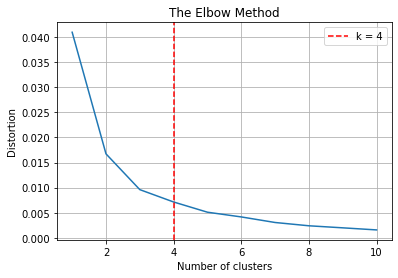

In [79]:
X = pitt_df[["lat","lng"]]
max_k = 10
## iterations
distortions = [] 
for i in range(1, max_k+1):
    if len(X) >= i:
        model = cluster.KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        model.fit(X)
        distortions.append(model.inertia_)
        
## best k: the lowest derivative
k = [i*100 for i in np.diff(distortions,2)].index(min([i*100 for i in np.diff(distortions,2)]))

## plot
fig, ax = plt.subplots()
ax.plot(range(1, len(distortions)+1), distortions)
ax.axvline(k, ls='--', color="red", label="k = "+str(k))
ax.set(title='The Elbow Method', xlabel='Number of clusters', ylabel="Distortion")
ax.legend()
ax.grid(True)
plt.show()

**Let's use k=4 as that seems to be the best choice here.**

In [80]:
k = 4
model = cluster.KMeans(n_clusters=k, init='k-means++')
X = pitt_df[["lat","lng"]]

## clustering
dtf_X = X.copy()
dtf_X["cluster"] = model.fit_predict(X)

## find real centroids
closest, distances = vq(model.cluster_centers_, dtf_X.drop("cluster", axis=1).values)
dtf_X["centroids"] = 0
for i in closest:
    dtf_X["centroids"].iloc[i] = 1
    
## add clustering info to the original dataset
pitt_df[["cluster","centroids"]] = dtf_X[["cluster","centroids"]]
pitt_df.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,neighborhood,crossStreet,id,cluster,centroids
0,Pizza Milano,Pizza Place,1304 5th Ave,40.438582,-79.987962,"[{'label': 'display', 'lat': 40.4385821185373,...",390,15219,US,Pittsburgh,PA,United States,"[1304 5th Ave, Pittsburgh, PA 15219, United St...",NaN,NaN,4ade2a17f964a520807321e3,3,0
1,Pizza Parma,Pizza Place,963 Liberty Ave,40.443770,-79.995820,"[{'label': 'display', 'lat': 40.44377, 'lng': ...",537,15222,US,Pittsburgh,PA,United States,"[963 Liberty Ave, Pittsburgh, PA 15222, United...",NaN,NaN,4b761d05f964a5208f3d2ee3,0,0
2,Genoa Pizza and Bar,Pizza Place,111 Market St,40.439001,-80.003671,"[{'label': 'display', 'lat': 40.43900068922535...",1189,15222,US,Pittsburgh,PA,United States,"[111 Market St, Pittsburgh, PA 15222, United S...",NaN,NaN,4b166f06f964a52005b923e3,0,0
3,Domino's Pizza,Pizza Place,300 6th Ave Uppr 100,40.441832,-79.999361,"[{'label': 'display', 'lat': 40.44183246264836...",785,15222,US,Pittsburgh,PA,United States,"[300 6th Ave Uppr 100, Pittsburgh, PA 15222, U...",NaN,NaN,4c7fdfe22f1c236ab0952143,0,1
4,Napoli's Pizza,Pizza Place,1525 5th Ave,40.438725,-79.984352,"[{'label': 'display', 'lat': 40.43872451782226...",587,15219,US,Pittsburgh,PA,United States,"[1525 5th Ave, Pittsburgh, PA 15219, United St...",NaN,NaN,4da518c24df00f31b175f0db,3,0


**Plot the clusters and centroids to better visualize the data:**

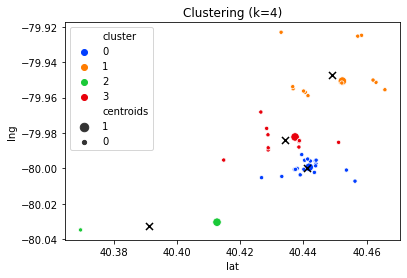

In [82]:
import seaborn as sns
## plot
fig, ax = plt.subplots()
sns.scatterplot(x="lat", y="lng", data=pitt_df, palette=sns.color_palette("bright",k), hue='cluster', size="centroids", size_order=[1,0], legend="brief", ax=ax).set_title('Clustering (k='+str(k)+')')
th_centroids = model.cluster_centers_
ax.scatter(th_centroids[:,0], th_centroids[:,1], s=50, c='black', marker="x")

In [83]:
pitt_df['cluster'].value_counts().max(level=0)

0    21
3    14
1    13
2     2
Name: cluster, dtype: int64

**Wow, 21 restaurants just like our other city.**
<br>
Since Cluster 0 and Cluster 3 are so close together, let me change the number of **k** and see what the data gives us.

In [85]:
k = 3
model = cluster.KMeans(n_clusters=k, init='k-means++')
X = pitt_df[["lat","lng"]]

## clustering
dtf_X = X.copy()
dtf_X["cluster"] = model.fit_predict(X)

## find real centroids
closest, distances = vq(model.cluster_centers_, dtf_X.drop("cluster", axis=1).values)
dtf_X["centroids"] = 0
for i in closest:
    dtf_X["centroids"].iloc[i] = 1
    
## add clustering info to the original dataset
pitt_df[["cluster","centroids"]] = dtf_X[["cluster","centroids"]]

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


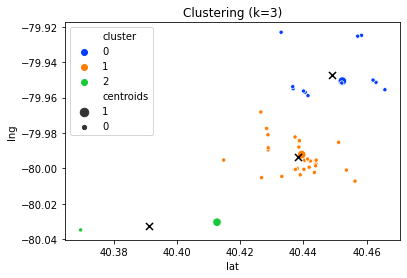

In [87]:
import seaborn as sns
## plot
fig, ax = plt.subplots()
sns.scatterplot(x="lat", y="lng", data=pitt_df, palette=sns.color_palette("bright",k), hue='cluster', size="centroids", size_order=[1,0], legend="brief", ax=ax).set_title('Clustering (k='+str(k)+')')
th_centroids = model.cluster_centers_
ax.scatter(th_centroids[:,0], th_centroids[:,1], s=50, c='black', marker="x")

In [88]:
pitt_df['cluster'].value_counts().max(level=0)

1    35
0    13
2     2
Name: cluster, dtype: int64

**That data looks much better. Now let's find the centroid of Cluster 1:**

In [90]:
pitt_cluster_df = pitt_df[(pitt_df['cluster'] == 1) & (pitt_df['centroids'] == 1)]
pitt_cluster_df

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,neighborhood,crossStreet,id,cluster,centroids
19,Pizza Bosa,Pizza Place,741 5th Ave,40.439485,-79.992222,"[{'label': 'display', 'lat': 40.439485, 'lng':...",305,15219,US,Pittsburgh,PA,United States,"[741 5th Ave, Pittsburgh, PA 15219, United Sta...",NaN,NaN,58d53f700802cb155727ccb8,1,1


**Pizza Bosa in Pittsburgh would be the closest restaurant we would want to center our delivery service around.**
<br>
There are 35 restaurants in close proximity to this restaurant. We will be able to offer delivery service of those restaurants to our customers.

<hr>

## Conclusion:

**Upon analysis, we discovered that opening our Pizza Delivery service in Pittsburgh would be the best choice.**
<br><br>
As close to latitude and longitude of **(40.439485, -79.992222)** as we can get!

In [122]:
lat = pitt_cluster_df.lat.values[0]
lng = pitt_cluster_df.lng.values[0]
best_spot_map = folium.Map(location=[lat,lng], zoom_start=16)

folium.CircleMarker(
    [lat,lng],
    radius=15,
    color='darkred',
    popup='Best Spot to Open',
    fill=True,
    fill_color='darkred',
    fill_opacity=0.6
).add_to(best_spot_map)

best_spot_map

Map Link: https://github.com/theblindhobo/Coursera_Capstone/blob/master/Screenshot%202020-11-02%20200847.png